<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-corvus18/blob/main/Actividad_Semanal_7_ACT2_K_MEANS_A01114918.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Actividad Semanal 7: K means**

Felipe de Jesus Gastelum Lizarraga - A01114918

Ciencia y analítica de datos (Gpo 10)

Profesora: María de la Paz Rico Fernández

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [21]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [23]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [24]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [26]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

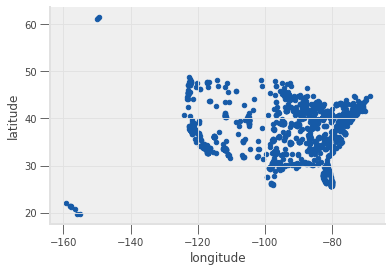

In [27]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [28]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [29]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [30]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [31]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [32]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [33]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

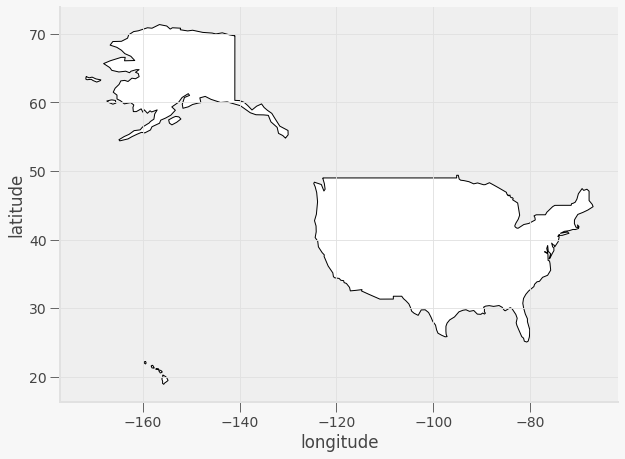

In [34]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

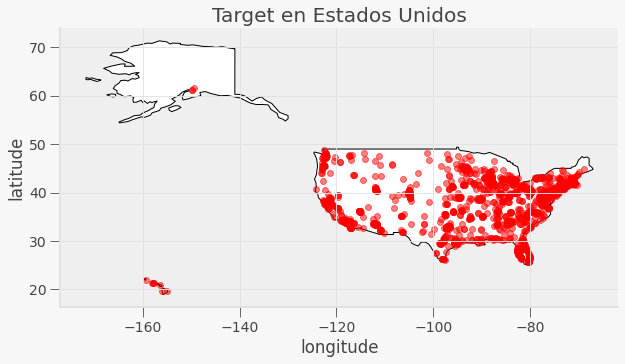

In [35]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

In [45]:
from sklearn.cluster import KMeans
from pandas.core.internals.concat import concat_arrays

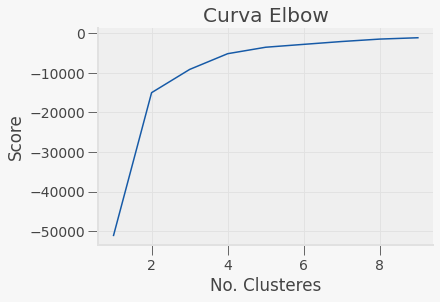

In [37]:
nclusters = range(1,10)
KM = [KMeans(n_clusters=i) for i in nclusters]

miY = latlong[['latitude']]
miX = latlong[['longitude']]

sco = [KM[i].fit(miY).score(miY) for i in range(len(KM))]

# Visualizar
plt.plot(nclusters, sco)
plt.xlabel('No. Clusteres')
plt.ylabel('Score')
plt.title('Curva Elbow')
plt.show()

Usar 3 Clusteres

In [38]:
KM3 = KMeans(n_clusters = 3, init ='k-means++')
KM3.fit(latlong[latlong.columns[0:2]])
titulos = KM3.labels_
titulos

array([0, 0, 0, ..., 2, 0, 2], dtype=int32)

In [39]:
lon_lat = df[["longitude","latitude"]]
KM3 = KMeans(n_clusters=3).fit(lon_lat)
centroids = KM3.cluster_centers_ # Los cdentroides son los centros de cada kmean, hasta aqui son dos columnas de coorddenadas
labels = KM3.predict(lon_lat)
# Getting the cluster centers
C = KM3.cluster_centers_

C_DF = pd.DataFrame(C) #Hacemos un dataframe con las dos columnas de las coordenadas
C_DF["Coordinates"] = list(zip(C_DF[0], C_DF[1])) #Aqui cibvertimos el dataframe a lista, para despues pasarlos a puntos coordenadas
C_DF["Coordinates"] = C_DF["Coordinates"].apply(Point) #Aqui creamos los puntos coordenadas a partir del datagrame


gdf_C = gpd.GeoDataFrame(C_DF, geometry="Coordinates") #Geopandas, necesita  puntos coordenadas para 
gdf_C

,0,1,Coordinates
0,-118.624473,37.487342,POINT (-118.62447 37.48734)
1,-78.534390,37.782609,POINT (-78.53439 37.78261)
2,-93.279950,37.987914,POINT (-93.27995 37.98791)


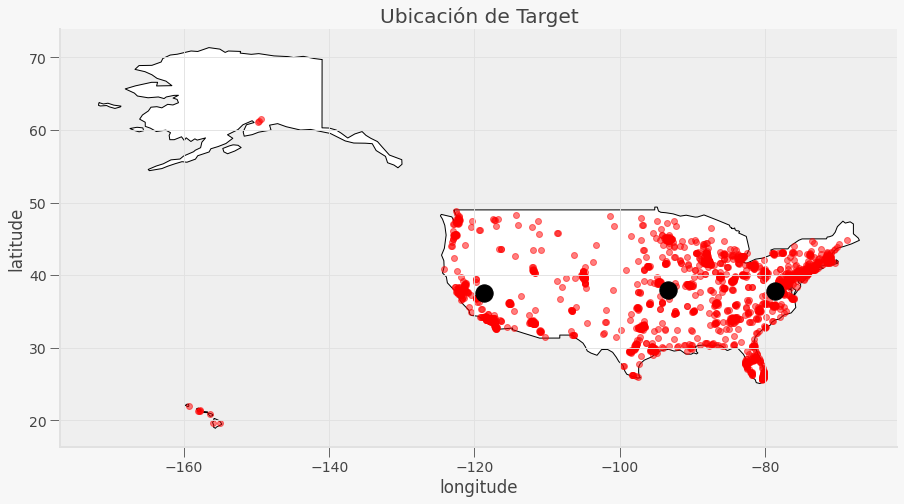

In [40]:
fig, gax = plt.subplots(figsize=(15,10))
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')
gdf.plot(ax=gax, color='red', alpha = 0.5) #Aqui grafica los datos originales
gdf_C.plot(ax=gax, color='black', alpha = 1, markersize = 300) #Aqui grafica los datos de nuestro dataset de arriba

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Ubicación de Target')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [44]:
latlong['kmeans'] = KM3.labels_ 
latlong.loc[:, 'kmeans'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1    826
2    628
0    385
Name: KM3, dtype: int64

In [46]:
Location1 = str(gdf_C[1][0]) + ", " + str(gdf_C[0][0]) #Aqui es alrevez, osea la coordenada x esta en la columna 1, y la y en la columna 0 , por eso medio misterioso esta llamada
print(Location1)
Location2 = str(gdf_C[1][1]) + ", " + str(gdf_C[0][1])
print(Location2)
Location3 = str(gdf_C[1][2]) + ", " + str(gdf_C[0][2])
print(Location3)

37.48734203064935, -118.62447331844157
37.78260864094776, -78.53438980340219
37.98791363565769, -93.27994961093502


**Las Ciudades de los Almacenes:**




In [54]:
from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim 
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="my-application") 
Locations = [Location1, Location2, Location3]
for i in Locations:
  location = geolocator.reverse(i)
  print('Ciudades:')
  print(location.address)


dist1 = str(geodesic(Location1, Location2).kilometers)
print("\n\n\nDistancia entre primera y segunda ciudad : ", dist1, " km \n") 
dist2 = str(geodesic(Location2, Location3).kilometers)
print("Distancia entre segunda y tercera : ", dist2, " km \n")


Ciudades:
Paradise Estates, Mono County, California, United States
Ciudades:
James River Road, Scottsville, Albemarle County, Virginia, 24590, United States
Ciudades:
State Highway U, Hickory County, Missouri, 65668, United States



Distancia entre primera y segunda ciudad :  3511.0344877546113  km 

Distancia entre segunda y tercera :  1295.997385147  km 



El numero de Almacenes esta dado por el numero optimo de clusteres ideales para el metodo K-Means, los datos son agrupados en base a caracteristicas similares, en este caso la latitud y longitud. La curva Elbow nos ayuda a identificar la cantidad de grupos adecuada para clasificar los datos, en este caso sera el numero almacenes.

**¿qué librerías nos pueden ayudar a graficar este tipo de datos?**

Algunas librerias para visualizar mapas en Python son:

**GeoPandas:**

permite analizar relaciones espaciales de diferentes geometrías, realiza geocodificación, hacer mapas, etc..

**GeoPy:**

Te permite acceder a a servicios de geocodificación, localizar las coordenadas de direcciones, ciudades, países y puntos de referencia en todo el mundo mediante geocodificadores de terceros y otras fuentes de datos.

**Geemap:**

Permite generar mapas interactivos con Google Earth Engine (GEE).


**¿Consideras importante que se grafique en un mapa?**

Si, ya que una de las mejores formas de enviar un mensaje a la audiencia o comunicar algo es a través de herramientas visuales. Un mapa es una excelente manera de resumir datos geográficos.

**Conclusiones**

El método K-Means es una herramienta que nos permite conocer como está estructurada la información y de qué manera esta puede ser clasificada en base a ciertas características. Identificar grupo de datos es de gran utilidad si se requiere realizar análisis de segmentación, campañas personalizadas, detectar potenciales segmentos de mercado, etc.